In [1]:
import skimage
from skimage import draw
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

from plot_helpers import show_image
from dataset_helpers import get_label

In [128]:
from dataset_helpers import max_normalise

In [2]:
npzfile = np.load('/Users/Leonore/Desktop/dmso_unmodified.npz')
x = npzfile['x']
y = npzfile['y']

In [3]:
y_dmso = [get_label(file) for file in y]

In [131]:
x_dmso = np.reshape(x, (len(x), 192, 192))

In [132]:
for idx, img in enumerate(x_dmso):
    x_dmso[idx] = max_normalise(img)

# Structural Similarity Index

In [113]:
from skimage.metrics import structural_similarity as ssi

In [130]:
ssi(max_normalise(x[3]), max_normalise(x[103])) 

0.8180580104720478

In [ ]:
idx = 0
ss_indices = np.ndarray(shape=(len(x)//2, 2))
j = 0
while idx < 19600:
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        print(idx, idx+100)
        tcell = get_mask(x[idx])
        dcell = get_mask(x[idx+100])
        overlaps[j, :] = [iou(tcell, dcell), get_label(y[idx])]
        idx+=1
        j+=1 

# Evaluating overlap

In [13]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    mask = np.copy(a)
    for idx, pixel in enumerate(a):
        if pixel == val:
            mask[idx] = 1
        else:
            mask[idx] = 0
    return mask.astype(np.uint8)

In [16]:
def get_mask(img):
    kmeans = KMeans(2).fit(img.reshape(np.prod(img.shape), 1))
    return convert_to_binary(kmeans.cluster_centers_[kmeans.labels_])

In [24]:
def iou(a,b):
    i = a & b
    u = a | b
    return (np.sum(i==1)/np.sum(u==1))*100

In [ ]:
idx = 0
overlaps = np.ndarray(shape=(len(x)//2, 2))
j = 0
while idx < 19600:
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        print(idx, idx+100)
        tcell = get_mask(max_normalise(x[idx]))
        dcell = get_mask(max_normalise(x[idx+100]))
        overlaps[j, :] = [iou(tcell, dcell), get_label(y[idx])]
        idx+=1
        j+=1 

0 100
1 101
2 102
3 103
4 104
5 105
6 106
7 107
8 108
9 109
10 110
11 111
12 112
13 113
14 114
15 115
16 116
17 117
18 118
19 119
20 120
21 121
22 122
23 123
24 124
25 125
26 126
27 127
28 128
29 129
30 130
31 131
32 132
33 133
34 134
35 135
36 136
37 137
38 138
39 139
40 140
41 141
42 142
43 143
44 144
45 145
46 146
47 147
48 148
49 149
50 150
51 151
52 152
53 153
54 154
55 155
56 156
57 157
58 158
59 159
60 160
61 161
62 162
63 163
64 164
65 165
66 166
67 167
68 168
69 169
70 170
71 171
72 172
73 173
74 174
75 175
76 176
77 177
78 178
79 179
80 180
81 181
82 182
83 183
84 184
85 185
86 186
87 187
88 188
89 189
90 190
91 191
92 192
93 193
94 194
95 195
96 196
97 197
98 198
99 199
200 300
201 301
202 302
203 303
204 304
205 305
206 306
207 307
208 308
209 309
210 310
211 311
212 312
213 313
214 314
215 315
216 316
217 317
218 318
219 319
220 320
221 321
222 322
223 323
224 324
225 325
226 326
227 327
228 328
229 329
230 330
231 331
232 332
233 333
234 334
235 335
236 336
237 337
238 33

1831 1931
1832 1932
1833 1933
1834 1934
1835 1935
1836 1936
1837 1937
1838 1938
1839 1939
1840 1940
1841 1941
1842 1942
1843 1943
1844 1944
1845 1945
1846 1946
1847 1947
1848 1948
1849 1949
1850 1950
1851 1951
1852 1952
1853 1953
1854 1954
1855 1955
1856 1956
1857 1957
1858 1958
1859 1959
1860 1960
1861 1961
1862 1962
1863 1963
1864 1964
1865 1965
1866 1966
1867 1967
1868 1968
1869 1969
1870 1970
1871 1971
1872 1972
1873 1973
1874 1974
1875 1975
1876 1976
1877 1977
1878 1978
1879 1979
1880 1980
1881 1981
1882 1982
1883 1983
1884 1984
1885 1985
1886 1986
1887 1987
1888 1988
1889 1989
1890 1990
1891 1991
1892 1992
1893 1993
1894 1994
1895 1995
1896 1996
1897 1997
1898 1998
1899 1999
2000 2100
2001 2101
2002 2102
2003 2103
2004 2104
2005 2105
2006 2106
2007 2107
2008 2108
2009 2109
2010 2110
2011 2111
2012 2112
2013 2113
2014 2114
2015 2115
2016 2116
2017 2117
2018 2118
2019 2119
2020 2120
2021 2121
2022 2122
2023 2123
2024 2124
2025 2125
2026 2126
2027 2127
2028 2128
2029 2129
2030 2130


3451 3551
3452 3552
3453 3553
3454 3554
3455 3555
3456 3556
3457 3557
3458 3558
3459 3559
3460 3560
3461 3561
3462 3562
3463 3563
3464 3564
3465 3565
3466 3566
3467 3567
3468 3568
3469 3569
3470 3570
3471 3571
3472 3572
3473 3573
3474 3574
3475 3575
3476 3576
3477 3577
3478 3578
3479 3579
3480 3580
3481 3581
3482 3582
3483 3583
3484 3584
3485 3585
3486 3586
3487 3587
3488 3588
3489 3589
3490 3590
3491 3591
3492 3592
3493 3593
3494 3594
3495 3595
3496 3596
3497 3597
3498 3598
3499 3599
3600 3700
3601 3701
3602 3702
3603 3703
3604 3704
3605 3705
3606 3706
3607 3707
3608 3708
3609 3709
3610 3710
3611 3711
3612 3712
3613 3713
3614 3714
3615 3715
3616 3716
3617 3717
3618 3718
3619 3719
3620 3720
3621 3721
3622 3722
3623 3723
3624 3724
3625 3725
3626 3726
3627 3727
3628 3728
3629 3729
3630 3730
3631 3731
3632 3732
3633 3733
3634 3734
3635 3735
3636 3736
3637 3737
3638 3738
3639 3739
3640 3740
3641 3741
3642 3742
3643 3743
3644 3744
3645 3745
3646 3746
3647 3747
3648 3748
3649 3749
3650 3750


5071 5171
5072 5172
5073 5173
5074 5174
5075 5175
5076 5176
5077 5177
5078 5178
5079 5179
5080 5180
5081 5181
5082 5182
5083 5183
5084 5184
5085 5185
5086 5186
5087 5187
5088 5188
5089 5189
5090 5190
5091 5191
5092 5192
5093 5193
5094 5194
5095 5195
5096 5196
5097 5197
5098 5198
5099 5199
5200 5300
5201 5301
5202 5302
5203 5303
5204 5304
5205 5305
5206 5306
5207 5307
5208 5308
5209 5309
5210 5310
5211 5311
5212 5312
5213 5313
5214 5314
5215 5315
5216 5316
5217 5317
5218 5318
5219 5319
5220 5320
5221 5321
5222 5322
5223 5323
5224 5324
5225 5325
5226 5326
5227 5327
5228 5328
5229 5329
5230 5330
5231 5331
5232 5332
5233 5333
5234 5334
5235 5335
5236 5336
5237 5337
5238 5338
5239 5339
5240 5340
5241 5341
5242 5342
5243 5343
5244 5344
5245 5345
5246 5346
5247 5347
5248 5348
5249 5349
5250 5350
5251 5351
5252 5352
5253 5353
5254 5354
5255 5355
5256 5356
5257 5357
5258 5358
5259 5359
5260 5360
5261 5361
5262 5362
5263 5363
5264 5364
5265 5365
5266 5366
5267 5367
5268 5368
5269 5369
5270 5370


6691 6791
6692 6792
6693 6793
6694 6794
6695 6795
6696 6796
6697 6797
6698 6798
6699 6799
6800 6900
6801 6901
6802 6902
6803 6903
6804 6904
6805 6905
6806 6906
6807 6907
6808 6908
6809 6909
6810 6910
6811 6911
6812 6912
6813 6913
6814 6914
6815 6915
6816 6916
6817 6917
6818 6918
6819 6919
6820 6920
6821 6921
6822 6922
6823 6923
6824 6924
6825 6925
6826 6926
6827 6927
6828 6928
6829 6929
6830 6930
6831 6931
6832 6932
6833 6933
6834 6934
6835 6935
6836 6936
6837 6937
6838 6938
6839 6939
6840 6940
6841 6941
6842 6942
6843 6943
6844 6944
6845 6945
6846 6946
6847 6947
6848 6948
6849 6949
6850 6950
6851 6951
6852 6952
6853 6953
6854 6954
6855 6955
6856 6956
6857 6957
6858 6958
6859 6959
6860 6960
6861 6961
6862 6962
6863 6963
6864 6964
6865 6965
6866 6966
6867 6967
6868 6968
6869 6969
6870 6970
6871 6971
6872 6972
6873 6973
6874 6974
6875 6975
6876 6976
6877 6977
6878 6978
6879 6979
6880 6980
6881 6981
6882 6982
6883 6983
6884 6984
6885 6985
6886 6986
6887 6987
6888 6988
6889 6989
6890 6990


8411 8511
8412 8512
8413 8513
8414 8514
8415 8515
8416 8516
8417 8517
8418 8518
8419 8519
8420 8520
8421 8521
8422 8522
8423 8523
8424 8524
8425 8525
8426 8526
8427 8527
8428 8528
8429 8529
8430 8530
8431 8531
8432 8532
8433 8533
8434 8534
8435 8535
8436 8536
8437 8537
8438 8538
8439 8539
8440 8540
8441 8541
8442 8542
8443 8543
8444 8544
8445 8545
8446 8546
8447 8547
8448 8548
8449 8549
8450 8550
8451 8551
8452 8552
8453 8553
8454 8554
8455 8555
8456 8556
8457 8557
8458 8558
8459 8559
8460 8560
8461 8561
8462 8562
8463 8563
8464 8564
8465 8565
8466 8566
8467 8567
8468 8568
8469 8569
8470 8570
8471 8571
8472 8572
8473 8573
8474 8574
8475 8575
8476 8576
8477 8577
8478 8578
8479 8579
8480 8580
8481 8581
8482 8582
8483 8583
8484 8584
8485 8585
8486 8586
8487 8587
8488 8588
8489 8589
8490 8590
8491 8591
8492 8592
8493 8593
8494 8594
8495 8595
8496 8596
8497 8597
8498 8598
8499 8599
8600 8700
8601 8701
8602 8702
8603 8703
8604 8704
8605 8705
8606 8706
8607 8707
8608 8708
8609 8709
8610 8710


10026 10126
10027 10127
10028 10128
10029 10129
10030 10130
10031 10131
10032 10132
10033 10133
10034 10134
10035 10135
10036 10136
10037 10137
10038 10138
10039 10139
10040 10140
10041 10141
10042 10142
10043 10143
10044 10144
10045 10145
10046 10146
10047 10147
10048 10148
10049 10149
10050 10150
10051 10151
10052 10152
10053 10153
10054 10154
10055 10155
10056 10156
10057 10157
10058 10158
10059 10159
10060 10160
10061 10161
10062 10162
10063 10163
10064 10164
10065 10165
10066 10166
10067 10167
10068 10168
10069 10169
10070 10170
10071 10171
10072 10172
10073 10173
10074 10174
10075 10175
10076 10176
10077 10177
10078 10178
10079 10179
10080 10180
10081 10181
10082 10182
10083 10183
10084 10184
10085 10185
10086 10186
10087 10187
10088 10188
10089 10189
10090 10190
10091 10191
10092 10192
10093 10193
10094 10194
10095 10195
10096 10196
10097 10197
10098 10198
10099 10199
10200 10300
10201 10301
10202 10302
10203 10303
10204 10304
10205 10305
10206 10306
10207 10307
10208 10308
1020

11409 11509
11410 11510
11411 11511
11412 11512
11413 11513
11414 11514
11415 11515
11416 11516
11417 11517
11418 11518
11419 11519
11420 11520
11421 11521
11422 11522
11423 11523
11424 11524
11425 11525
11426 11526
11427 11527
11428 11528
11429 11529
11430 11530
11431 11531
11432 11532
11433 11533
11434 11534
11435 11535
11436 11536
11437 11537
11438 11538
11439 11539
11440 11540
11441 11541
11442 11542
11443 11543
11444 11544
11445 11545
11446 11546
11447 11547
11448 11548
11449 11549
11450 11550
11451 11551
11452 11552
11453 11553
11454 11554
11455 11555
11456 11556
11457 11557
11458 11558
11459 11559
11460 11560
11461 11561
11462 11562
11463 11563
11464 11564
11465 11565
11466 11566
11467 11567
11468 11568
11469 11569
11470 11570
11471 11571
11472 11572
11473 11573
11474 11574
11475 11575
11476 11576
11477 11577
11478 11578
11479 11579
11480 11580
11481 11581
11482 11582
11483 11583
11484 11584
11485 11585
11486 11586
11487 11587
11488 11588
11489 11589
11490 11590
11491 11591
1149

In [100]:
unstimulated = overlaps[overlaps[:, 1] == 0, 0]
ova = overlaps[overlaps[:, 1] == 1, 0]
cona = overlaps[overlaps[:, 1] == 2, 0]

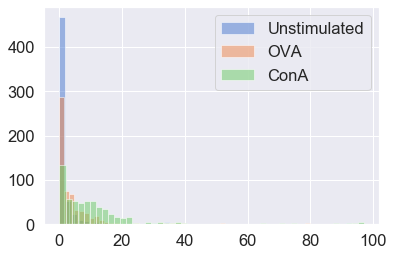

In [107]:
plt.hist(unstimulated[:600], bins=50, alpha=0.5, label="Unstimulated")
plt.hist(ova[:600], bins=50, alpha=0.5, label="OVA")
plt.hist(cona[:600], bins=50, alpha=0.5, label="ConA")
plt.legend()
plt.show()

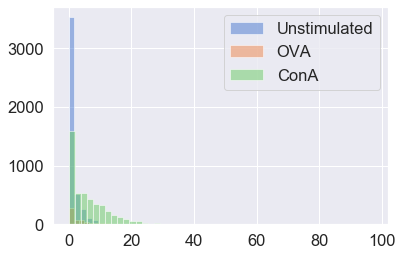

In [106]:
plt.hist(unstimulated, bins=50, alpha=0.5, label="Unstimulated")
plt.hist(ova, bins=50, alpha=0.5, label="OVA")
plt.hist(cona, bins=50, alpha=0.5, label="ConA")
plt.legend()
plt.show()

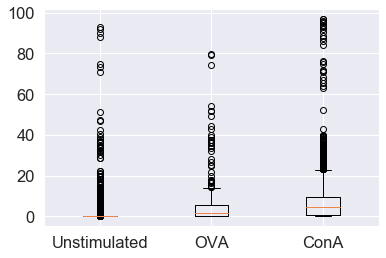

In [57]:
fig = plt.boxplot([overlaps[overlaps[:, 1] == 0], overlaps[overlaps[:, 1] == 1, 0], overlaps[overlaps[:, 1] == 2, 0]])
xticks = plt.xticks([1,2,3], ["Unstimulated", "OVA", "ConA"])

## K-Means Colour Clustering

In [142]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [225]:
green_img = np.reshape(x[3], (192*192, 1))

In [226]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(green_img,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [227]:
center = np.uint8(center)

In [228]:
res = center[label.flatten()]
green_result = res.reshape((192, 192))

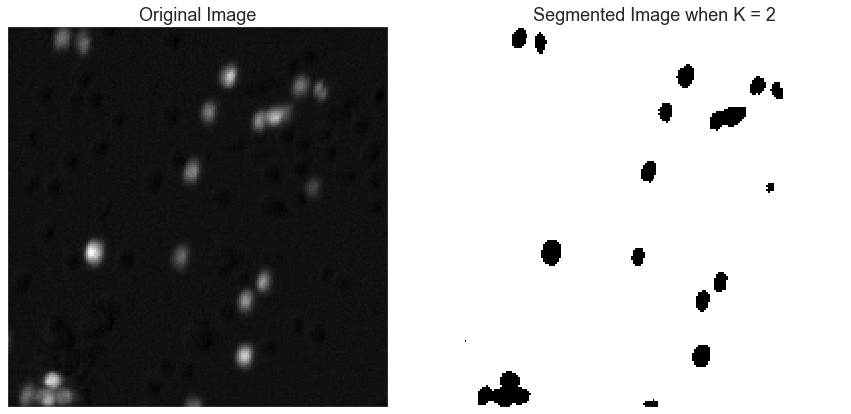

In [229]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[3], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(green_result, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [230]:
red_img = np.reshape(x[103], (192*192, 1))

In [189]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(red_img,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [190]:
center = np.uint8(center)

In [191]:
res = center[label.flatten()]
red_result = res.reshape((192, 192))

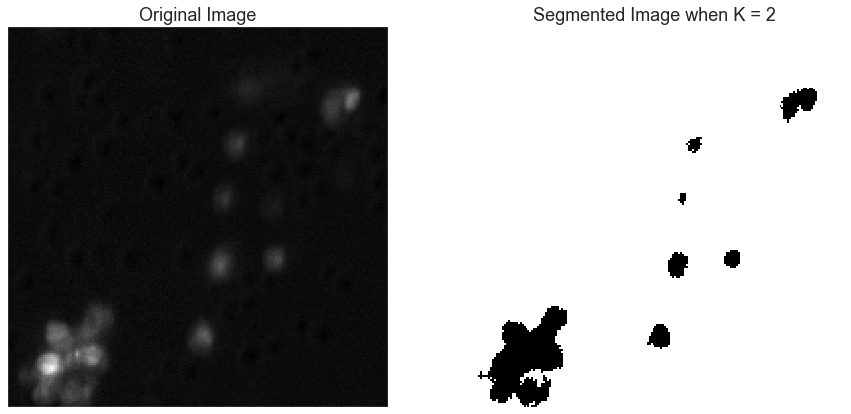

In [192]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[103], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(red_result, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [234]:
kmeans = KMeans(K).fit(green_img)

In [239]:
res = kmeans.cluster_centers_[kmeans.labels_]
green_result_2 = res.reshape((192, 192))

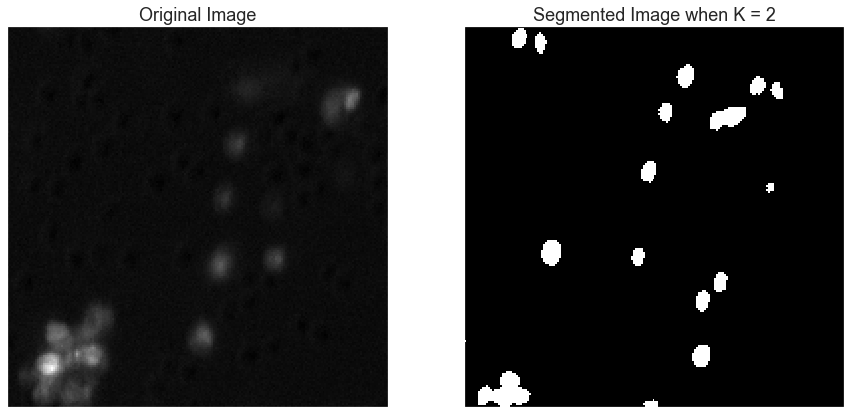

In [240]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[103], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(green_result_2, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [274]:
green = get_mask(x[3])

In [275]:
red = get_mask(x[103])

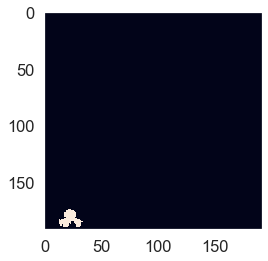

In [75]:
plt.imshow(np.reshape(green & red, (192, 192)))
plt.grid(False)

In [96]:
img = np.ndarray(shape=(192, 192, 3))
img[:, :, 0] = red.reshape(192, 192)
img[:, :, 1] = green.reshape(192, 192)

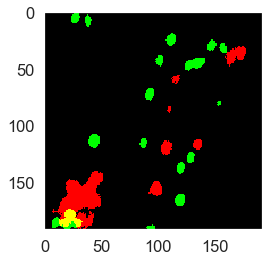

In [98]:
plt.imshow(img)
plt.grid(False)

## Intersection over union

In [109]:
# using skimage.draw.circle
c1 = np.zeros((64,64))
# cx, cy set position; radius sets... the radius.
r,c = skimage.draw.circle(c=c1.shape[1]/3, r=c1.shape[0]/2, radius=10)
c1[r,c]=1

In [110]:
# using skimage.draw.circle
c2 = np.zeros((64,64))
# cx, cy set position; radius sets... the radius.
r,c = skimage.draw.circle(c=c2.shape[1]/2, r=c2.shape[0]/2, radius=11)
c2[r,c]=1

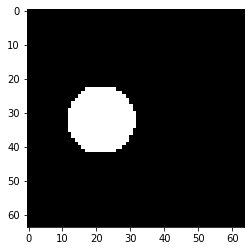

In [80]:
plt.imshow(c1, cmap="gray")

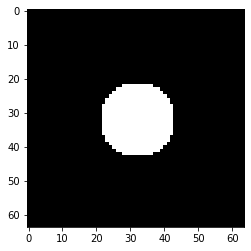

In [81]:
plt.imshow(c2, cmap="gray")

In [74]:
t = c1.astype("bool") & c2.astype("bool")

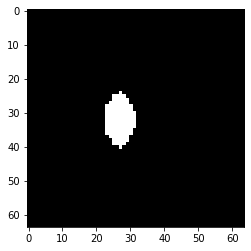

In [78]:
plt.imshow(t.astype("uint8"), cmap="gray")

In [112]:
iou(c1.astype("bool"), c2.astype("bool"))

23.508137432188065